# Resource competition in variable environments

#### Andrew D. Letten (andrew.letten@usys.ethz.ch)


<sub>Disclaimer: There is (unfortunately) quite a bit of code in this notebook, but you are not expected to understand everything it does! Instead, the emphasis is on understanding the concepts and on how small parameter changes can have large consequences for competitive outcomes.</sub>

## 1. Resource competition at equilibrium (review)

### 1.1 Two consumers and a single abiotic resource

In an equilibrium environment, where a single resource is delivered to a system at constant rate, all else being equal, coexistence of competitors is not possible. The winning consumer is the one that can draw the resource down to the lowest level (i.e. has the lowest R$^*$). This is a resource-explicit statement of the principle of **Competitive Exclusion**


Remember, if the per-capita growth rate is defined as a Monod function, i.e.

\begin{equation}
\frac{dN_{i}}{dt} = N_{i}(\frac{\mu _{max_{i}}R}{k_{i} + R} - d)
\end{equation}


then, 

\begin{equation}
R^* = \frac{dk_{i}}{\mu_{max_{i}}  - d}
\end{equation}

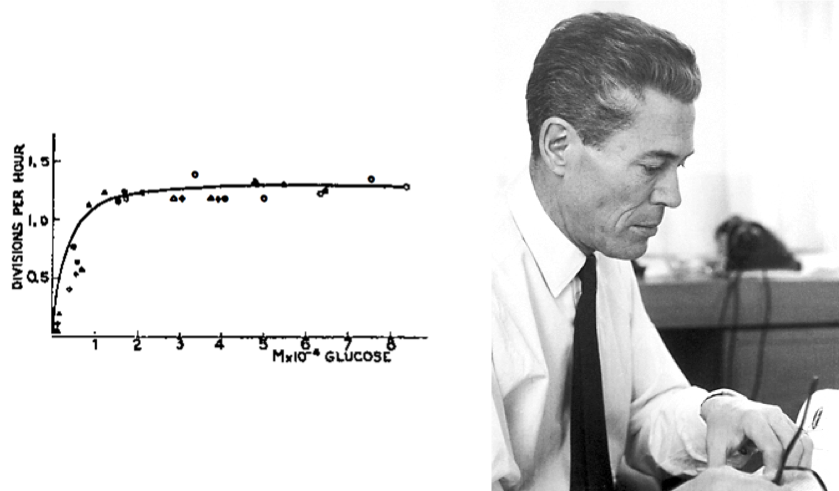
Jacques Monod, Nobel Prize winner and key figure in the French Resistance (see [Carroll, S.B. 2013. "Brave Genius"](https://www.amazon.com/Brave-Genius-Philosopher-Adventures-Resistance/dp/0307952339))

In [25]:
# Required packages
library(dplyr, warn.conflicts = FALSE)
library(tidyr)
library(ggplot2)
library(cowplot, warn.conflicts = FALSE)
library(deSolve)
library(IRdisplay)
options(repr.plot.width=4, repr.plot.height=4)
cbbPalette = c("#E69F00", "#56B4E9", "#009E73", "#F0E442")

Define function for Monod functional response

In [26]:
# Monod function
monod.sim = function(x = R, r = r, k = k){
  per.cap = r*x/(k+x)
  return(per.cap)
}

<span style="color:blue"> *Choose growth parameters for consumer 1 & 2 and generate functional responses for plotting* </span>

In [33]:
r1 = 0.025; r2 = 0.025 # maximum growth rate
k1 = 0.01; k2 = 0.011 # half stauration constant
Q = 0.0001 # resource quota
d = 0.01 # density independent mortality
resource = 0.12 # resource supply concentration

In [34]:
resource.levels = seq(0,resource,by = 0.001) 
resp.blue = monod.sim(x = resource.levels, r = r1, k = k1)
resp.red = monod.sim(x = resource.levels, r = r2, k = k2)

monod.mat = data.frame(resource.levels,resp.blue,resp.red)
monod.gg = gather(monod.mat, key = resp, value = count, -resource.levels)
names(monod.gg)[2] = c("sp")

Plot Monod per-capita growth response to resource availability 

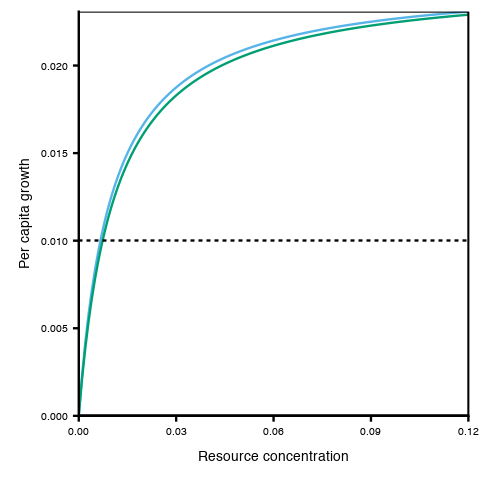

In [35]:
ggplot(monod.gg, aes(y = count, x = resource.levels)) +
  geom_line(aes(col = sp)) + 
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  xlab("Resource concentration") + ylab("Per capita growth") +
  panel_border(colour = "black") + geom_hline(yintercept = d, linetype = "dashed") + 
  theme(axis.text = element_text(size = 6),
        axis.title= element_text(size = 8)) +
  coord_cartesian(expand = FALSE)

Simulate the model

In [38]:
CRmod_2cons_1res = function(Time, State, Pars)
{
  with(as.list(c(State, Pars)),
       {
         dN1 = N1*r1*R/(k1+R) - d*N1
         dN2 = N2*r2*R/(k2+R) - d*N2
         dR =  d*(resource-R) - ((N1*R*r1*Q)/(k1+R)) - ((N2*R*r2*Q)/(k2+R))
         return(list(c(dN1, dN2, dR)))
       })
}

state.ini=c(N1=10, N2=10, R=resource)
model = CRmod_2cons_1res
times=round(seq(0.1,10000,by=0.1),1) # total number of time-steps

# Run the numerical simulations
out.monod=as.data.frame(ode(func=model,
                            y=state.ini,
                            parms=NULL,
                            times=times,
                            method = "lsoda"))

comp.gg = gather(out.monod, state.var, count, -time)

Plot model output (population size as a function of time)

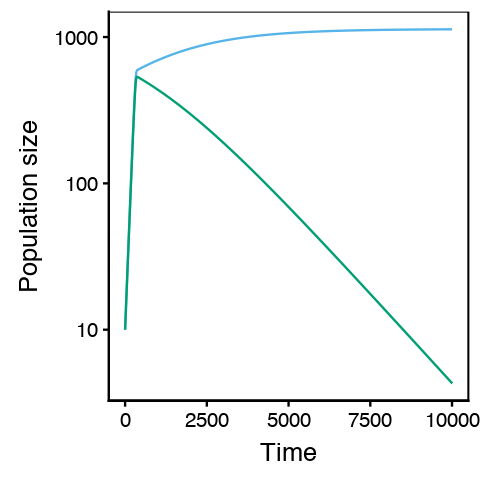

In [39]:
ggplot(comp.gg[comp.gg$state.var != "R",], aes(y = count, x= time)) +
  geom_line(aes(group = state.var, col = state.var)) + scale_y_log10() +
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  ylab(expression(paste("Population size"))) + xlab("Time") +
  panel_border(colour = "black") +
  theme(axis.text = element_text(size = 12),
        axis.title= element_text(size = 15)) 

### 1.2 Two consumers and two abiotic resources

With two resources, two consumers can coexist at equilibrium if:

- 1) Each species is a better competitor for a different resource
- 2) Each consumes more of the resource that it most benefits from (is most limited by);
- 3) The resource supply ratio does not overly favour one species over the other.

-----------------

Choose model parameters (i.e. consumer growth rate, mortality rate, resource concentration etc.) For simiplicty we will assume linear growth responses.

In [8]:
parmat = matrix(nrow = 2, ncol = 2)
parmat[1,] = c(0.4, 0.8) # Consumer 1 (blue)
parmat[2,] = c(0.6, 0.5) # Consumer 2 (green)
Q = 0.1 # resource quota
d = 0.1 # density independant mortality rate
resource_a = 0.3 # starting supply of resource_a
resource_b = 0.3 # # starting supply of resource_b

Calculate ZNGIs for plotting

In [9]:
one.a.star = d/parmat[1,1]
one.b.star = d/parmat[1,2]
two.a.star = d/parmat[2,1]
two.b.star = d/parmat[2,2]

slope.1 = (0 - one.a.star)/(one.b.star - 0)
slope.2 = (0 - two.a.star)/(two.b.star - 0)

eqRb = (two.a.star - one.a.star)/(slope.1 - slope.2)
eqRa = (slope.1*two.a.star - slope.2*one.a.star)/(slope.1 - slope.2)
ZNGI.df = data.frame(bl = c(resource_b), ob = c(resource_a))

Plot ZNGIs, impact vectors and resource supply on resource phase plane 

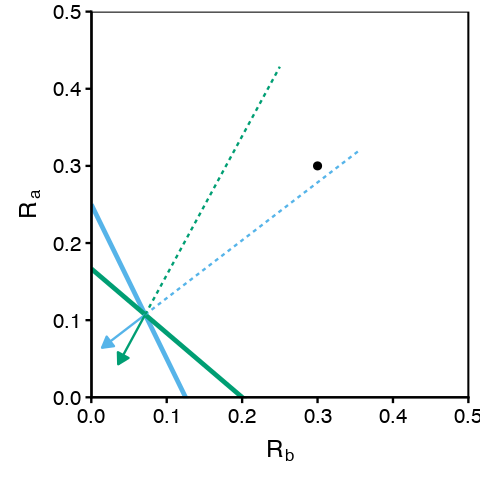

In [10]:
ggplot() +
  scale_x_continuous(limits = c(0, 0.5), expand = c(0,0)) +
  scale_y_continuous(limits = c(0, 0.5), expand = c(0,0)) +
  geom_abline(intercept=one.a.star, slope=slope.1, col=cbbPalette[2], lwd=1) +
  geom_abline(intercept=two.a.star, slope=slope.2, col=cbbPalette[3], lwd=1) +
  xlab(expression(italic(R[b]))) + ylab(expression(italic(R[a]))) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa-Q*eqRa*parmat[1,1]*10, xend = eqRb-Q*eqRb*parmat[1,2]*10), size = 0.5, col=cbbPalette[2], arrow = arrow(type = "closed", length = unit(0.1, "inches"))) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa-Q*eqRa*parmat[2,1]*10, xend = eqRb-Q*eqRb*parmat[2,2]*10), size = 0.5, col=cbbPalette[3], arrow = arrow(type = "closed", length = unit(0.1, "inches"))) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa+Q*eqRa*parmat[1,1]*50, xend = eqRb+Q*eqRb*parmat[1,2]*50), size = 0.5, col=cbbPalette[2], linetype = 2) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa+Q*eqRa*parmat[2,1]*50, xend = eqRb+Q*eqRb*parmat[2,2]*50), size = 0.5, col=cbbPalette[3], linetype = 2) +
  geom_point(colour = "black", size = 3) +
  panel_border(colour = "black") + geom_point(data = ZNGI.df, aes(x = bl, y = ob)) #geom_line(data = out.mod, aes(x = Rb, y = Ra), col = "green")

Simulate model:

In [11]:
CRmod_2cons_2res = function(Time, State, Pars)
{
  with(as.list(c(State, Pars)),
       {
         dN1 = N1*r1a*Ra + N1*r1b*Rb - d*N1
         dN2 = N2*r2a*Ra + N2*r2b*Rb - d*N2
         dRa =  d*(resource_a - Ra) - (N1*Ra*r1a*Q) - ((N2*Ra*r2a*Q)) 
         dRb =  d*(resource_b - Rb) - (N1*Rb*r1b*Q) - ((N2*Rb*r2b*Q))
         return(list(c(dN1, dN2, dRa, dRb)))
       })
}

In [12]:
parmat = matrix(nrow = 2, ncol = 2)
parmat[1,] = c(0.4, 0.8) # Consumer 1 (blue)
parmat[2,] = c(0.6, 0.5) # Consumer 2 (green)
r1a = parmat[1,1]; r1b = parmat[1,2]
r2a = parmat[2,1]; r2b = parmat[2,2]
Q = 0.001 # resource quota
d = 0.1 # density independant mortality rate

<span style="color:blue"> *Once you've run the model once, try run it again with different resource supply ratios (predict what should happen before running the model)* </span>

In [13]:
resource_a = 0.3 # starting supply of resource_a
resource_b = 0.1 # # starting supply of resource_b

In [14]:
state.ini=c(N1=10, N2=10, Ra=resource_a, Rb=resource_b)
model = CRmod_2cons_2res
times=round(seq(0.1,1000,by=0.1),1) # total number of time-steps

# Run the numerical simulations
out.mod=as.data.frame(ode(func=model,
                            y=state.ini,
                            parms=NULL,
                            times=times,
                            method = "lsoda"))

comp.gg = gather(out.mod, state.var, count, -time)

In [15]:
dynamic_plot = ggplot(comp.gg[comp.gg$state.var != "Ra" & comp.gg$state.var != "Rb",], aes(y = count, x= time)) +
  geom_line(aes(group = state.var, col = state.var)) + scale_y_log10() +
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  ylab(expression(paste("Population size"))) + xlab("Time") +
  panel_border(colour = "black") +
  theme(axis.text = element_text(size = 12),
        axis.title= element_text(size = 15)) 

one.a.star = d/parmat[1,1]
one.b.star = d/parmat[1,2]
two.a.star = d/parmat[2,1]
two.b.star = d/parmat[2,2]

slope.1 = (0 - one.a.star)/(one.b.star - 0)
slope.2 = (0 - two.a.star)/(two.b.star - 0)

eqRb = (two.a.star - one.a.star)/(slope.1 - slope.2)
eqRa = (slope.1*two.a.star - slope.2*one.a.star)/(slope.1 - slope.2)
ZNGI.df = data.frame(bl = c(resource_b), ob = c(resource_a))

zngi_plot = ggplot() +
  scale_x_continuous(limits = c(0, 0.5), expand = c(0,0)) +
  scale_y_continuous(limits = c(0, 0.5), expand = c(0,0)) +
  geom_abline(intercept=one.a.star, slope=slope.1, col=cbbPalette[2], lwd=1) +
  geom_abline(intercept=two.a.star, slope=slope.2, col=cbbPalette[3], lwd=1) +
  xlab(expression(italic(R[b]))) + ylab(expression(italic(R[a]))) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa-Q*eqRa*parmat[1,1]*1000, xend = eqRb-Q*eqRb*parmat[1,2]*1000), size = 0.5, col=cbbPalette[2], arrow = arrow(type = "closed", length = unit(0.1, "inches"))) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa-Q*eqRa*parmat[2,1]*1000, xend = eqRb-Q*eqRb*parmat[2,2]*1000), size = 0.5, col=cbbPalette[3], arrow = arrow(type = "closed", length = unit(0.1, "inches"))) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa+Q*eqRa*parmat[1,1]*5000, xend = eqRb+Q*eqRb*parmat[1,2]*5000), size = 0.5, col=cbbPalette[2], linetype = 2) +
  geom_segment(aes(y = eqRa, x = eqRb, yend = eqRa+Q*eqRa*parmat[2,1]*5000, xend = eqRb+Q*eqRb*parmat[2,2]*5000), size = 0.5, col=cbbPalette[3], linetype = 2) +
  geom_point(colour = "black", size = 3) +
  panel_border(colour = "black") + geom_point(data = ZNGI.df, aes(x = bl, y = ob)) +
  geom_line(data = out.mod, aes(x = Rb, y = Ra), col = "green") # plot resource dynamics on phase plane



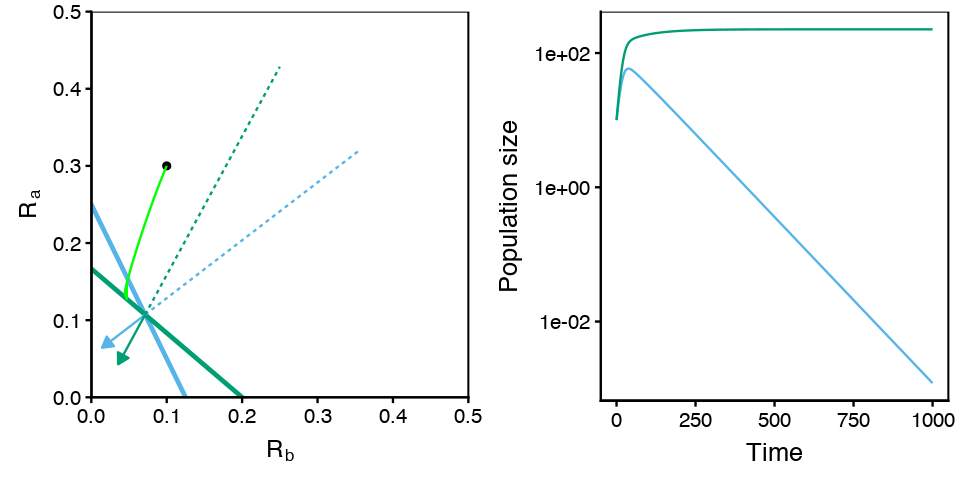

In [16]:
options(repr.plot.width=8, repr.plot.height=4)
plot_grid(zngi_plot, dynamic_plot)

## 2. Resource competition in non-equilibrium environments (new material)

In non-equilibrium environments, populations fluctuate through time due to variability in resource supply or other environmental factors such as temperature, rainfall, antibiotic exposure etc. The winner may not be the consumer with the lowest R*, and coexistence of two species on a single limiting resource is possible. 

### 2.1 Pulsed resources (depletable factors)

Consider an environment where resources are delivered in pulses (e.g. nutrients to the mammalian gut, rainfall...). Having a low R* may be maladaptive if a competitor with a high growth rate at high resources levels rapidly depletes the resource, leaving a too short window in which the low R* species is the superior competitor.

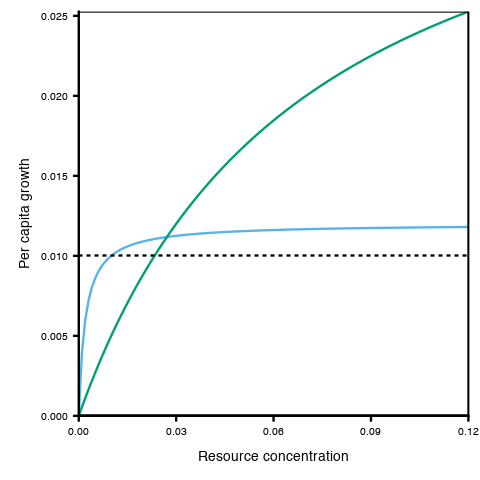

In [17]:
r1 = 0.012; r2 = 0.04 # maximum growth rate
k1 = 0.002; k2 = 0.07 # half stauration constant
Q = 0.0001 # resource quota
d = 0.01 # density independent mortality
resource = 0.12 # resource supply concentration

resource.levels = seq(0,resource,by = 0.001) 
resp.blue = monod.sim(x = resource.levels, r = r1, k = k1)
resp.red = monod.sim(x = resource.levels, r = r2, k = k2)

monod.mat = data.frame(resource.levels,resp.blue,resp.red)
monod.gg = gather(monod.mat, key = resp, value = count, -resource.levels)
names(monod.gg)[2] = c("sp")

options(repr.plot.width=4, repr.plot.height=4)

ggplot(monod.gg, aes(y = count, x = resource.levels)) +
  geom_line(aes(col = sp)) + 
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  xlab("Resource concentration") + ylab("Per capita growth") +
  panel_border(colour = "black") + geom_hline(yintercept = d, linetype = "dashed") + 
  theme(axis.text = element_text(size = 6),
        axis.title= element_text(size = 8)) +
  coord_cartesian(expand = FALSE)

In [18]:
pulse = 1 # time between resource pulses
a = exp(-d*pulse) # fraction of resource transferred for a given pulse rate, but constant total resource flux
time.total = 10000 # real length of simulation
times=round(seq(0.1,time.total,by=0.1),1) # total number of time-steps
res.pulse = seq(pulse, time.total, by = pulse) # pulse time-series

eventfun.respulse = function(Time, State, Pars){
  with(as.list(State),{
    N1 = N1 
    N2 = N2 
    R = (a)*R + resource*(1-a)
    return(c(N1, N2, R))
  })
}

CRmod_2cons_1res_pulsed = function(Time, State, Pars)
{
  with(as.list(c(State, Pars)),
       {
         dN1 = N1*r1*R/(k1+R) - d*N1
         dN2 = N2*r2*R/(k2+R) - d*N2
         dR =  - ((N1*R*r1*Q)/(k1+R)) - ((N2*R*r2*Q)/(k2+R))
         return(list(c(dN1, dN2, dR)))
       })
}

state.ini=c(N1=10, N2=10, R=resource)
model = CRmod_2cons_1res_pulsed

# Run the numerical simulations
out.monod=as.data.frame(ode(func=model,
                            y=state.ini,
                            parms=NULL,
                            times=times,
                            method = "lsoda", event = list(func = eventfun.respulse, time = res.pulse)))

comp.gg = gather(out.monod, state.var, count, -time)

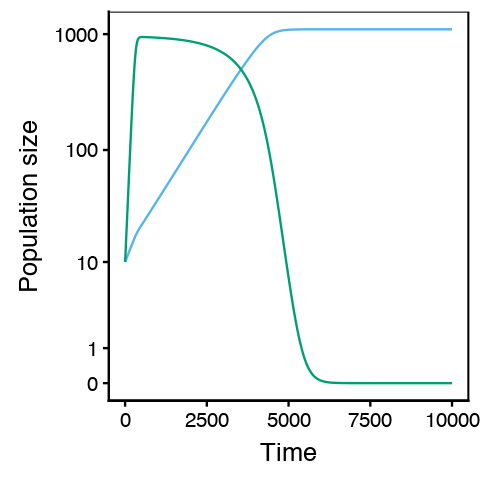

In [19]:
ggplot(comp.gg[comp.gg$state.var != "R",], aes(y = count, x= time)) +
  geom_line(aes(group = state.var, col = state.var)) + 
  scale_y_continuous(breaks=c(0,1,10,100,1000,4000), trans="log1p") +
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  ylab(expression(paste("Population size"))) + xlab("Time") +
  panel_border(colour = "black") +
  theme(axis.text = element_text(size = 12),
        axis.title= element_text(size = 15)) 

For a range of intermediate length resource pulses, these two species can actually stable coexist via an opportunist-gleaner trade-off, or in the jargon of coexistence theory: "**relative nonlinearity of competition**". 

Stable coexistence arises because the species with the lower R* (blue) increases the variance in the resource which benefits the species with the higher maximum growth rate (green). Converesly, green reduces variance in the resource which benefits blue. The result is that each can invade when the other is resident in the 'community'.

### 2.1 Environmental fluctuations (non-depletable factors)


Another mechanisms that can allow species to coexist on a single resource arises when species have different responses to some environmental factor that is variable in time (or space), is termed the **storage effect**. Coexistence under a temporal storage effect arises from temporal niche partitioning, the idea that species have a time-share of their common resource/habitat. More specifically, it relies on the esoteric concept of **density dependance in environment-competition covariance**, which simply means that when a species is dominant in a system (**high density**) and the environment switches to favour it, it will experience high levels of intra-specific competition, i.e. strong covariance between the favourability of the environment and the intensity of competition. This limits the gains it can make. Conversely, when a species is rare in a system (**low density**) and the environment switches to favour it, it experiences both low intra- and low inter-specific competition, i.e. weak covariance between the favourability of the environment and the intensity of competition. As a result it is able to take full advantage of those favourable conditions.

We can illustrate a temporal storage effect by making the parameters of a consumer resource model functions of the environment. 

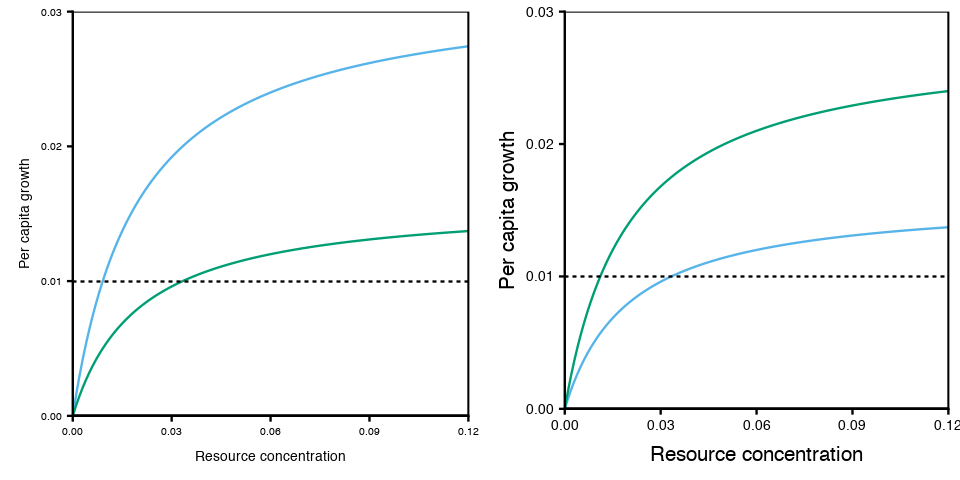

In [20]:
r1.opt = 0.032; r2.opt = 0.028
r1.sub = 0.016; r2.sub = 0.016
k1.opt = 0.02; k2.opt = 0.02
k1.sub = 0.02; k2.sub = 0.02
Q = 0.0001 # resource quota
d = 0.01 # density independent mortality
resource = 0.12 # resource supply concentration

resp.blue.1 = monod.sim(x = resource.levels, r = r1.opt, k = k1.opt)
resp.green.1 = monod.sim(x = resource.levels, r = r2.sub, k = k2.sub)
resp.blue.2 = monod.sim(x = resource.levels, r = r1.sub, k = k1.sub)
resp.green.2 = monod.sim(x = resource.levels, r = r2.opt, k = k2.opt)

monod.mat = data.frame(resource.levels,resp.blue.1,resp.green.1, resp.blue.2,resp.green.2)

monod.gg = gather(monod.mat, key = resp, value = count, -resource.levels)
monod.gg = data.frame(monod.gg, matrix(unlist(strsplit(monod.gg$resp, split = "\\W+")), ncol = 3, byrow = TRUE)[,2:3])
names(monod.gg)[4:5] = c("sp", "treatment")

monod.plot1 = ggplot(monod.gg[monod.gg$treatment == "1",], aes(y = count, x = resource.levels)) + #monod.gg$resp == "resp.blue.1" | monod.gg$resp == "resp.green.1",]
  geom_line(aes(col = sp, linetype = treatment)) + 
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  xlab("Resource concentration") + ylab("Per capita growth") +
  panel_border(colour = "black") + geom_hline(yintercept = d, linetype = "dashed") + 
  theme(axis.text = element_text(size = 6),
        axis.title= element_text(size = 8)) + ylim(0,0.03) +
  coord_cartesian(expand = FALSE)

monod.plot2 = ggplot(monod.gg[monod.gg$treatment == "2",], aes(y = count, x = resource.levels)) + #monod.gg$resp == "resp.blue.1" | monod.gg$resp == "resp.green.1",]
  geom_line(aes(col = sp, linetype = treatment)) + 
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  xlab("Resource concentration") + ylab("Per capita growth") +
  panel_border(colour = "black") + geom_hline(yintercept = d, linetype = "dashed") + 
  theme(axis.text = element_text(size = 8),
        axis.title= element_text(size = 12)) + ylim(0,0.03) +
  coord_cartesian(expand = FALSE)

options(repr.plot.width=8, repr.plot.height=4)

plot_grid(monod.plot1, monod.plot2)

In [21]:
# Set up time steps
time.total = 10000 # real length of simulation
times=round(seq(0.1,time.total,by=0.1),1) # total number of time-steps

# Event parameters (not in ODE function)
envperiod = 128 # time between environmental swithcing

## Time dependence 
r1.time = rep(c(rep(r1.opt, times = envperiod),rep(r1.sub,times = envperiod)), length.out = time.total)
r2.time = rep(c(rep(r2.sub, times = envperiod),rep(r2.opt,times = envperiod)), length.out = time.total)
k1.time = rep(c(rep(k1.opt, times = envperiod),rep(k1.sub,times = envperiod)), length.out = time.total)
k2.time = rep(c(rep(k2.sub, times = envperiod),rep(k2.opt,times = envperiod)), length.out = time.total)

# Make time dependent functions
timedep.param.df = data.frame(hour = c(0.1:time.total), r1 = r1.time, r2 = r2.time, k1 = k1.time, k2 = k2.time) 
r1.approx = approxfun(x = timedep.param.df$hour, y = timedep.param.df$r1, rule = 2, method = "constant")
r2.approx = approxfun(x = timedep.param.df$hour, y = timedep.param.df$r2, rule = 2, method = "constant")
k1.approx = approxfun(x = timedep.param.df$hour, y = timedep.param.df$k1, rule = 2, method = "constant")
k2.approx = approxfun(x = timedep.param.df$hour, y = timedep.param.df$k2, rule = 2, method = "constant")

CRmod_2cons_1res_fluct = function(Time, State, Pars)
{
  with(as.list(c(State, Pars)),
{
  r1 = r1.approx(Time)
  r2 = r2.approx(Time)
  k1 = k1.approx(Time)
  k2 = k2.approx(Time)
  dN1 = N1*r1*R/(k1+R) - d*N1
  dN2 = N2*r2*R/(k2+R) - d*N2
  dR =  d*(resource-R) - ((N1*R*r1*Q)/(k1+R)) - ((N2*R*r2*Q)/(k2+R))
  return(list(c(dN1, dN2, dR)))
})
}


In [22]:
state.ini=c(N1=10, N2=10, R=resource)
model = CRmod_2cons_1res_fluct

# Run the numerical simulations
out.monod=as.data.frame(ode(func=model,
                            y=state.ini,
                            parms=NULL,
                            times=times,
                            method = "lsoda"))

comp.gg = gather(out.monod, state.var, count, -time)

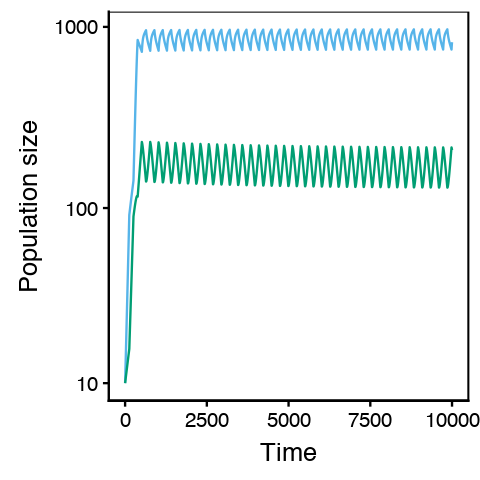

In [23]:
options(repr.plot.width=4, repr.plot.height=4)

ggplot(comp.gg[comp.gg$state.var != "R",], aes(y = count, x= time)) +
  geom_line(aes(group = state.var, col = state.var)) + 
  scale_y_continuous(breaks=c(0,1,10,100,1000,4000), trans="log1p") +
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  ylab(expression(paste("Population size"))) + xlab("Time") +
  panel_border(colour = "black") +
  theme(axis.text = element_text(size = 12),
        axis.title= element_text(size = 15)) 

Warning message:
“Removed 189998 rows containing missing values (geom_path).”

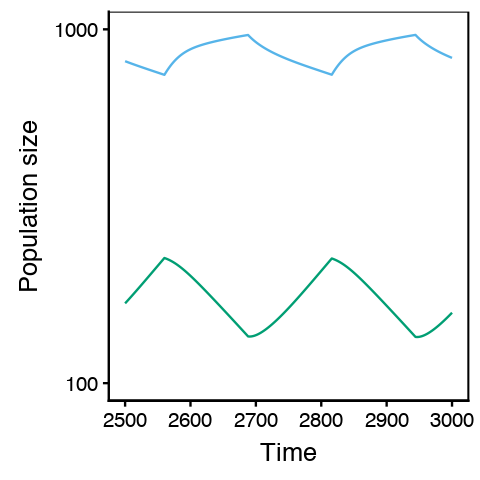

In [24]:
ggplot(comp.gg[comp.gg$state.var != "R",], aes(y = count, x= time)) +
  geom_line(aes(group = state.var, col = state.var)) + 
  scale_y_log10(limits = c(100,1000)) + 
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  ylab(expression(paste("Population size"))) + xlab("Time") +
  panel_border(colour = "black") +
  theme(axis.text = element_text(size = 12),
        axis.title= element_text(size = 15)) +
  xlim(2500,3000)